# 01: Convex Hulls

*Authors: Jan Erik Swiadek, Prof. Dr. Kevin Buchin*

This notebook serves as supplementary learning material for the course **Geometric Algorithms**.
It showcases implementations of algorithms and data structures presented in the lecture, and it elaborates on some practical considerations concerning their use.
Furthermore, it provides interactive visualisations and animations.

## Table of Contents


1. Imports  
2. Introduction  
3. Algorithms  
    3.1. Naive Hull  
    3.2. Graham Scan  
    3.3. Gift Wrapping  
    3.4. Chan's Hull  
4. References  

## 1. Imports

First let's import everything we need throughout this notebook, including our module for common geometry operations and data structures as well as our module for visualisation purposes.
The geometry module will probably receive its own notebook later.

In [1]:
# Python standard library imports
from typing import Optional

# External library imports
import numpy as np

# Make our modules available for importing
import os
import sys
modules_dir = os.path.abspath("../modules")
if modules_dir not in sys.path:
    sys.path.append(modules_dir)

# Geometry and visualisation module imports
from geometry import Orientation as ORT, Point, PointReference, Polygon
from visualisation import Visualisation

Additionally, we create a Visualisation object and register a few test instances for it.

In [2]:
visualisation = Visualisation(400, 400)
c = 200
d = 150

def circle_point(distance: int, degree: int) -> Point:
    return Point(c + distance * np.cos(degree * np.pi / 180), c + distance * np.sin(degree * np.pi / 180))
circle_instance = [circle_point(distance, degree) for distance in (d / 3, 2 * d / 3, d) for degree in range(0, 360, 30)]
np.random.shuffle(circle_instance)
visualisation.register_instance("Circles", circle_instance)

degenerate_instance =  [Point(c + i * d / 10, c + d - i * d / 10) for i in range(0, 10)]
degenerate_instance += [Point(c - i * d / 10, c - d + i * d / 10) for i in range(0, 10)]
degenerate_instance += [Point(c + d - i * d / 10, c - i * d / 10) for i in range(0, 10)]
degenerate_instance += [Point(c - d + i * d / 10, c + i * d / 10) for i in range(0, 10)]
degenerate_instance += [Point(c - d + i * d / 10, c) for i in range(1, 20)]
degenerate_instance += [Point(c, c - d + i * d / 10) for i in range(1, 20)]
np.random.shuffle(degenerate_instance)
visualisation.register_instance("Degeneracies", degenerate_instance)

robustness_instance = [
    Point(4.1, 101.0), Point(63.0, 6.9), Point(33.55, 53.95),
    Point(19.1, 187.0), Point(103.0, 22.9), Point(61.05, 104.95)
]
visualisation.register_instance("Robustness", robustness_instance)

## 2. Introduction

As a recap, here are the most important definitions from the lecture:

* A set of points *S* is **convex** if for any two points in the set, their connecting line segment is part of *S*.

* The **convex hull** of a set of points *P* is the smallest convex set that contains *P*.
  It is a convex polytope, whose vertices are points from *P*.

For example, the convex hull of the *Circles* instance defined above looks like this:

<img style="float: left;" src="../images/convex-hull-1.png">

## 3. Algorithms

Because computing convex hulls is a fundamental problem in computational geometry, many algorithms have been developed for solving it.
The lecture presented four of them with different strengths and weaknesses: Naive Hull, Graham Scan, Gift Wrapping, and Chan's Hull.
Let's take a closer look at their implementations.

### 3.1 Naive Hull

The first algorithm from the lecture makes use of the fact that for any edge of the convex hull, all other points lie to one side of the edge.
Using the convention from the lecture slides, they are supposed to lie to the left of the edge.
However, if we consider **degenerate cases**, which are common edge cases often left out in descriptions of geometric algorithms, this criterion is not sufficient.

Specifically, there could be three (or more) collinear points in the input set, i.e. points that all lie on a single line.
In that case, none of those points is to the left or right of an edge between two other of those points.
For a well-defined solution we want to include the outmost two of those points in the convex hull, while the middle point(s) should be left out.
To achieve that, we need add a second criterion to the validity test: All other points are supposed to lie either to the left of the edge or directly on the edge between the two points (see [1, pp. 4–5]).
If a point is found that violates both criteria, the edge is marked as invalid and is not included in the convex hull.

We assume that no two points in the input are the same, which is guaranteed by taking the input as a [Python set](https://docs.python.org/3.8/library/stdtypes.html#set-types-set-frozenset).

In [3]:
def naive_hull(points: set[Point]) -> Polygon:
    points = list(points)
    if len(points) <= 2:
        return Polygon(points)
    
    edges: dict[Point, Point] = {}
    for p in points:
        for q in filter(lambda q: q != p, points):
            valid = True
            for r in filter(lambda r: r != p and r != q, points):
                ort = r.orientation(p, q)
                if ort is not ORT.LEFT and ort is not ORT.BETWEEN:
                    valid = False
                    break
            if valid:
                edges[p] = q
    
    hull = Polygon()
    if edges:
        # Construct a list of ordered vertices from the collected edges.
        first_point, next_point = edges.popitem()
        hull.append(first_point)
        while next_point is not None and next_point != first_point:
            hull.append(next_point)
            next_point = edges.pop(next_point, None)
    
    return hull

Because of the naive nested loop, the algorithm's worst-case runtime complexity is in O(*n³* ), where *n* denotes the number of input points.

Let's register Naive Hull for visualisation.

In [4]:
visualisation.register_algorithm("Naive Hull", naive_hull)

Now you can interactively test the algorithm and watch animations of it!
You need to run the notebook cells for this purpose, so execute this notebook on [Binder](https://mybinder.org/) or on your local machine.
Before doing so, you will only see a static picture of an animation step on a random input instance below.
After running the following cell, you will instead see the interface of our visualisation tool.

The visualisation tool contains an interactive canvas on the left side.
You can add points to the canvas by clicking on it, up to a maximum of 999 points.
On the right side are control widgets divided into the these sections:

* **Canvas:** The *Clear canvas* button removes everything from the canvas.
  The *Random* button creates a random set of points with the specified size on the canvas.

* **Animation:** The *Animate* checkbox toggles whether to animate an executed algorithm instead of simply displaying its result.
  If the checkbox is selected, the *Speed* slider becomes visible.
  It controls the animation speed on a scale from 1 (slowest) to 10 (fastest).
  Note that it's not possible to stop a running animation.

* **Instances:** Each registered instance receives its own button that creates the associated set of points on the canvas.

* **Algorithms:** Each registered algorithm receives its own button that executes the algorithm on the points from the canvas.

* **Runtimes:** If an algorithm has been executed on the current set of canvas points, then its runtime is shown next to the corresponding button.

If you run the tool, then don't forget to execute Naive Hull on the registered instances, especially the *Degeneracies* and *Robustness* instances.

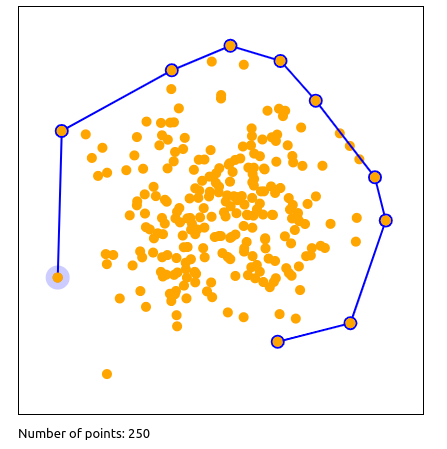

In [5]:
visualisation.display()

Even though Naive Hull handles degenerate cases as explained above and as demonstrated by its result on the *Degeneracies* instance, its implementation still doesn't return the correct answer for every input.
For example, it fails spectacularly at dealing with the seemingly harmless *Robustness* instance.

That's because floating point arithmetic is not exact and rounding errors can lead to problems.
Naive Hull in particular suffers from these so-called **robustness issues**, so it's not a **robust algorithm** (see [1, p. 5]).
Using correct arithmetic, e.g. through [Python's decimal library](https://docs.python.org/3/library/decimal.html), is unfortunately rather slow on most hardware.
For more information on robustness, see [1, pp. 8–10 and p. 14].

***Takeaways***:

* Algorithms with nested loops are often easy to conceive but inefficient.

* Correct geometric algorithms have to consider degenerate cases.

* Still, even a correct and simple algorithm can have robustness issues in practice.

### 3.2 Graham Scan

The second algorithm from the lecture is called **Graham Scan**.
It sorts the input points by ascending *x*-coordinate and scans them in this order to create the upper boundary of the convex hull.
After that, it scans the points in reverse order, i.e. sorted by descending *x*-coordinate, to create the lower boundary.
Each scan incrementally adds the sorted input points one by one, while eliminating points that don't contribute to right turns.
Therefore Graham Scan is an **incremental algorithm** (see [1, p. 6]).
Note that three points not making a right turn is equivalent to the middle point not being on the left side of the edge between the other two points.

The pseudocode from the lecture slides handles collinear points correctly, since collinear points don't make a turn at all and thus the middle points are eliminated.
At the same time, it doesn't consider the order of points with the same *x*-coordinate.
As it turns out, such points need to be sorted by their *y*-coordinate (see [1, p. 7]).

In [6]:
def graham_scan(points: set[Point]) -> Polygon:
    points = list(points)
    if len(points) <= 2:
        return Polygon(points)
    
    points.sort(key = lambda p: (p.x, p.y))
    upper_hull = _graham_single_scan(points)

    points.reverse()
    lower_hull = _graham_single_scan(points)

    return upper_hull + lower_hull[1:-1]

def _graham_single_scan(points: list[Point]) -> Polygon:
    hull = Polygon(points[:2])
    for p in points[2:]:
        hull.append(p)
        while len(hull) > 2 and hull[-2].orientation(hull[-3], hull[-1]) is not ORT.LEFT:
            del hull[-2]
    
    return hull

The asymptotic runtime of Graham Scan is in O(*n* log(*n*)), which is worst-case optimal (see [2, pp. 14–15]).

We register this algorithm for visualisation again.

In [7]:
visualisation.register_algorithm("Graham Scan", graham_scan)

Animations of Graham Scan are particularly pleasing to watch. Try it out!

Graham Scan is more robust than Naive Hull and handles the *Robustness* instance correctly, though rounding errors can still lead to wrong results in some cases (see [1, p. 7]).

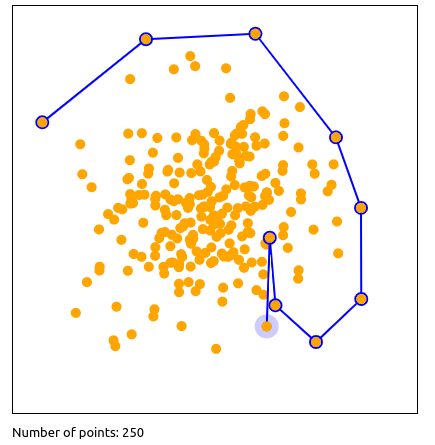

In [8]:
visualisation.display()

***Takeaways:***

* Designing algorithms incrementally is a useful technique.

* Sometimes, an efficient and fairly robust algorithm is nevertheless very simple.

* In fact, our implementation of Graham Scan consists of less code than that of Naive Hull.

### 3.3 Gift Wrapping

The next algorithm is **Gift Wrapping**, also called **Jarvis's March** (see [2, p. 15]).
It's an **output-sensitive algorithm**, meaning its runtime depends on the number of convex hull vertices.
Starting from an imaginary point at infinity and the rightmost (and in case of a tie, topmost) input point, which is guaranteed to be a convex hull vertex, each Gift Wrapping step searches for the point that maximises the righthand angle between the previous convex hull edge and the potential new edge.

Implementing this algorithm doesn't require to compute actual angles between edges.
Instead, we can make use of orientation tests again:
Consider two points *p* and *q* that we want to compare with respect to their corresponding angles.
Then *p* induces a bigger angle than *q* if and only if *p* is located to the left side of the directed edge from the current convex hull vertex to *q*.
If those three points are collinear, then *p* and *q* induce the same angle and we have to decide which point to prefer.
In that case, we regard *p* as better than *q* if *p* is located behind *q* from the perspective of the current convex hull vertex.
This results in the same well-defined solution as before.

In [9]:
def gift_wrapping(points: set[Point]) -> Polygon:
    points = list(points)
    if len(points) <= 2:
        return Polygon(points)
    
    first_point = max(points, key = lambda p: (p.x, p.y))
    wrapper = Wrapper()
    
    hull = Polygon([first_point])
    while True:
        next_point = wrapper.get_next_point(hull, points)
        if next_point == first_point or len(hull) == len(points):   # The second condition is a termination safeguard.
            break
        hull.append(next_point)

    return hull


class Wrapper:
    def __init__(self):
        self._current_point: Optional[Point] = None

    def get_next_point(self, hull: Polygon, points: list[Point]) -> Point:
        self._current_point = hull[-1]
        points_iterator = filter(lambda p: p != self._current_point, points)
        next_point = next(points_iterator)

        for p in points_iterator:
            if self._is_better(p, next_point):
                hull.animate(next_point)    # Animate next_point before updating it.
                next_point = p
        
        return next_point

    def _is_better(self, p: Point, q: Point) -> bool:
        ort = p.orientation(self._current_point, q)
        return ort is ORT.LEFT or ort is ORT.BEHIND_TARGET

Gift Wrapping's runtime is in O(*nh*), where *n* is the number of input points as usual and *h* denotes the number of convex hull vertices.

In [10]:
visualisation.register_algorithm("Gift Wrapping", gift_wrapping)

Have fun with the animations!

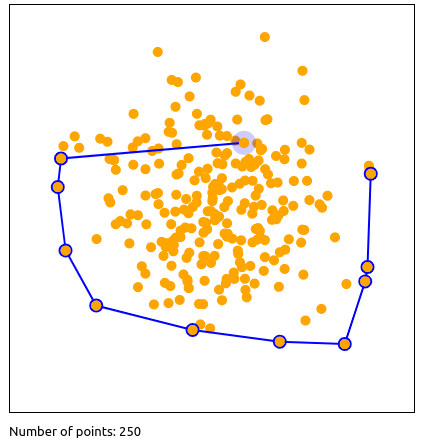

In [11]:
visualisation.display()

***Takeaways:***

* Asymptotic runtime complexity can additionally depend on the size of the output instead of just the input.

* Output-sensitive algorithms might be beneficial in specific scenarios, though they are hard to judge in the general case.

### 3.4 Chan's Hull

The final convex hull algorithm from the lecture is **Chan's Hull**, which combines Graham Scan and Gift Wrapping.
It first separates the *n* input points into *n/m* sets of size *m* and computes the convex hulls of these sets using Graham Scan.
A suitable value for the parameter *m* with *h <= m <= h²* is found by **repeatedly squaring** as shown in the lecture (see also [2, p. 19]).
Let's call the convex hulls resulting from this process *mini hulls*.
Next the Gift Wrapping technique is applied, but with the help of the mini hulls we can reduce the number of candidates and thus don't need to search through all *n* points.
That's possible because the mini hulls are convex polygons and their vertices are returned in cyclic order by Graham Scan, enabling us to find the best candidate from a mini hull, i.e. the vertex with the largest induced angle, in O(log(*m*)) time through "a variant of binary search" (see [2, p. 17] for a more detailed statement of this claim, though it also omits the proof and how the search exactly works).

Standard binary search is only applicable for monotone sequences, whereas we have to search for a vertex that is better than both its neighbours.
For so-called **unimodal sequences**, which consist of a monotonely ascending and a monotonely decreasing part, [Ternary search](https://en.wikipedia.org/wiki/Ternary_search) can be used.
If the first mini hull vertex is the worst one, the sequence of induced angles is indeed unimodal:
Starting with the smallest angle, it goes up until the angle of the best vertex is reached, then it goes down until the end.
Unfortunately, Ternary search isn't sufficient here either because the arbitrary cyclic order of mini hull vertices might result in one monotone part being split in two, i.e. the sequence of induced angles can be comprised of three parts with alternating monotonicity (e.g. up, then down, then up) and is therefore not necessarily unimodal.

We will not discuss the implementation of our binary search variant further.
The interested reader can study its core logic in the following *ChanWrapper.get_candidates()* method.
To make things even more complicated, handling the degenerate case of collinear points is quite intricate, since it can cause two neighbouring vertices to induce the same angle in the sequence.
Examining such two vertices doesn't tell us the direction in which the sequence is ascending, so the binary search indexes have to be adjusted in that case.
If necessary, this is done in the *ChanWrapper._calculate_indexes()* method.
Note that, to keep the code cleaner, our candidate search implementation might return more than one candidate, but it's limited to at most four candidates, which is an asymptotically constant amount per mini hull.

In [12]:
def chans_hull(points: set[Point]) -> Polygon:
    points = list(points)
    if len(points) <= 2:
        return Polygon(points)

    hull = None
    t = 0
    while hull is None:
        m = min(len(points), 2**(2**t))
        hull = _parametric_chans_hull(points, m)
        t += 1

    return hull

def _parametric_chans_hull(points: list[Point], m: int) -> Optional[Polygon]:
    mini_hulls: list[Polygon] = []
    point_references: list[PointReference] = []
    for start in range(0, len(points), m):
        end = min(len(points), start + m)
        mini_hull = graham_scan(points[start:end])
        mini_hulls.append(mini_hull)
        for position in range(0, len(mini_hull)):
            point_references.append(PointReference(mini_hull, position))

    first_point = max(point_references, key = lambda p: (p.x, p.y))
    wrapper = ChanWrapper()
    
    hull = Polygon([first_point])
    for _ in range(0, m):
        candidates: list[PointReference] = []
        for mini_hull in mini_hulls:
            candidates.extend(wrapper.get_candidates(hull, mini_hull))
        next_point = wrapper.get_next_point(hull, candidates)
        if next_point == first_point:
            return hull
        hull.append(next_point)

    if m == len(points):    # This is a termination safeguard.
        return hull
    return None


class ChanWrapper(Wrapper):
    def get_candidates(self, hull: Polygon, mini_hull: Polygon) -> list[PointReference]:
        self._current_point = hull[-1]
        if self._current_point.is_in_container(mini_hull):
            if len(mini_hull) == 1:
                return []
            next_position = (self._current_point.get_position() + 1) % len(mini_hull)
            return [PointReference(mini_hull, next_position)]

        l, mb, m, ma, r = self._calculate_indexes(mini_hull, 0, len(mini_hull) - 1)
        while l <= mb < m < ma <= r:
            m_better_than_before = self._is_better(mini_hull[m], mini_hull[mb])
            m_better_than_after = self._is_better(mini_hull[m], mini_hull[ma])
            if m_better_than_before and m_better_than_after:
                return [PointReference(mini_hull, m)]

            m_better_than_l = self._is_better(mini_hull[m], mini_hull[l])
            r_better_than_l = self._is_better(mini_hull[r], mini_hull[l])
            if r_better_than_l:
                if m_better_than_l and not m_better_than_before:
                    r = mb
                else:
                    l = ma
            else:
                if m_better_than_l and m_better_than_before:
                    l = ma
                else:
                    r = mb
            l, mb, m, ma, r = self._calculate_indexes(mini_hull, l, r)

        return [PointReference(mini_hull, position) for position in range(l, r + 1)]
    
    def _calculate_indexes(self, mini_hull: Polygon, l: int, r: int) -> tuple[int, int, int, int, int]:
        if l != r and self._has_same_angle(mini_hull[l], mini_hull[r]):
            if self._is_better(mini_hull[r], mini_hull[l]):
                l += 1
            else:
                r -= 1
        if r - l < 2:
            return l, 0, 0, 0, r

        m = int(l + (r - l) / 2)
        mb = m - 1
        ma = m + 1
        if self._has_same_angle(mini_hull[m], mini_hull[mb]):
            if self._is_better(mini_hull[mb], mini_hull[m]):
                m -= 1
            mb -= 1
        elif self._has_same_angle(mini_hull[m], mini_hull[ma]):
            if self._is_better(mini_hull[ma], mini_hull[m]):
                m += 1
            ma += 1
            
        return l, mb, m, ma, r

    def _has_same_angle(self, p: Point, q: Point) -> bool:
        ort = p.orientation(self._current_point, q)
        return ort is ORT.BETWEEN or ort is ORT.BEHIND_TARGET

Whew, that's quite a lot of code!
Especially considering that it relies on the preceding implementations of Graham Scan and Gift Wrapping.
Chan's Hull is not only the most complex algorithm in this notebook, but its degenerate cases also require very careful attention.
A perfect example for why they are typically skipped.

The algorithm's asymptotic runtime is in O(*n* log(*h*)), which is worst-case optimal in terms of input and output size (see [2, pp. 20–22]).
That means, from a theoretical perspective it's the best algorithm we've seen.
However, its practical performance incurs computational overhead due its complicated implementation.

In [13]:
visualisation.register_algorithm("Chan's Hull", chans_hull)

Having now registered all four algorithms, you could try comparing their runtimes for different inputs using our interactive visualisation tool.
Or you could simply watch animations of Chan's Hull, which visualise the respective mini hull of each added point.

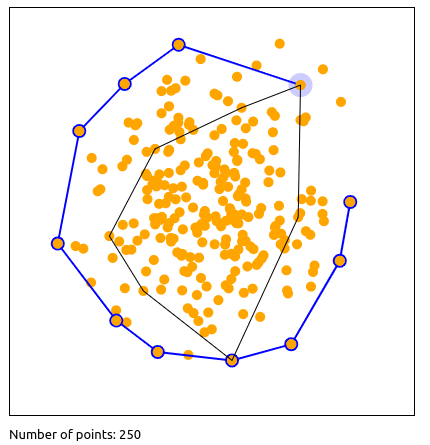

In [14]:
visualisation.display()

***Takeaways:***

* Combining algorithmic techniques can be surprisingly powerful.

* Sometimes, dealing with degenerate cases is nasty...

* The best asymptotic runtime complexity doesn't always result in the best actual runtime performance for all inputs.

## 4. References

[1] Mark de Berg, Otfried Cheong, Marc van Kreveld, and Mark Overmars. *Computational Geometry: Algorithms and Applications*, 3rd Edition, 2008.

[2] David M. Mount. [*CMSC 754: Computational Geometry*](https://www.cs.umd.edu/class/spring2020/cmsc754/Lects/cmsc754-spring2020-lects.pdf), 2020.